# Section 4.3: Survival Kernets Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement survival kernets (Chen, 2024) using PyTorch and PyCox (Chen's original code is written based on existing PyCox code). For an overview of survival kernets, please see Section 4.3 in the monograph. This demo is very similar to the DeepHit demo (`S2.3.3_DeepHit_single.ipynb`). Please look at the DeepHit demo first.

Note that the code for survival kernets in some sense supersedes the earlier deep kernel survival analysis (DKSA) model by Chen (2020)--covered in Section 4.2 of the monograph--since it is possible to set hyperparameters for survival kernets and set up the warm-start in a way that we recover the original DKSA approach.

The base neural network in this case is used to help compute a kernel function (i.e., a function that gives a similarity score between 0 and 1 for any two pairs of data points; a higher similarity score means that the two points are considered more similar).

Model training works as follows:

1. We first train an XGBoost model. The XGBoost model's predicted leaves for the data points are then used to warm-start base neural network training. Chen (2024) refers to this step as the "Tree ensemble Under a Neural Approximation" (TUNA) warm-start.
2. We then continue to train the base neural network using a negative log likelihood loss + a ranking loss (similar to DeepHit).
3. Finally, treating the base neural network as fixed (so that the kernel function is treated as fixed), we now treat the different exemplar/cluster summary functions as parameters that can be optimized (rather than having them be determined based on a Kaplan-Meier calculation). Chen (2024) refers to this step as "summary fine-tuning".

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Warm-start: Tree ensemble Under a Neural Approximation (TUNA)

The original deep kernel survival analysis paper (Chen, 2020) found warm-starting neural net training with random survival forests (Ishwaran et al., 2008) to be helpful (typically better than using standard neural net random parameter initialization). The problem is that random survival forests do not scale well to very large datasets. Chen (2024) subsequently showed how to instead use XGBoost (Chen and Guestrin, 2016) to warm-start neural net training. Note that XGBoost scales to very large datasets and also supports survival analysis.

#### Training an XGBoost model to help with warm-starting base neural net training

We begin by training an XGBoost model. For simplicity, we do not tune the hyperparameters of this XGBoost model aside from the number of rounds/trees used (where we use XGBoost's built-in early stopping functionality). In practice, one should try to tune this XGBoost model to make it as good as possible by, for instance, tuning hyperparameters using the validation set &mdash; no peeking at the test set of course. XGBoost's built-in early-stopping just uses whichever loss function we ask it to use, in this case the Cox loss. In practice, one could instead use a different validation set loss (for instance, Chen's XGBoost demo code evaluates Harrell's concordance index on the validation set to decide on how many iterations/trees to use: https://github.com/georgehc/survival-kernets/blob/main/demo_xgb.py).

In [3]:
import xgboost as xgb

# for the Cox model, XGBoost expects censored observations to be specified as negative
train_data_xgb = xgb.DMatrix(X_train_np,
                             label=Y_train_np * (2*(D_train_np - 0.5)))
val_data_xgb = xgb.DMatrix(X_val_np,
                           label=Y_val_np * (2*(D_val_np - 0.5)))

# note that there are many other hyperparameters that can be tuned -- see the XGBoost documentation for details
xgb_params = {'seed': 0,
              'eta': .1,
              'objective': 'survival:cox'}
max_num_rounds = 100
early_stopping = 10

xgb_model = xgb.train(xgb_params, train_data_xgb, max_num_rounds,
                      early_stopping_rounds=early_stopping,
                      evals=[(val_data_xgb, 'val')])

[0]	val-cox-nloglik:6.59471
[1]	val-cox-nloglik:6.58534
[2]	val-cox-nloglik:6.57637
[3]	val-cox-nloglik:6.57156
[4]	val-cox-nloglik:6.56784
[5]	val-cox-nloglik:6.56498
[6]	val-cox-nloglik:6.56092
[7]	val-cox-nloglik:6.55869
[8]	val-cox-nloglik:6.56051
[9]	val-cox-nloglik:6.55782
[10]	val-cox-nloglik:6.55753
[11]	val-cox-nloglik:6.55430
[12]	val-cox-nloglik:6.55883
[13]	val-cox-nloglik:6.55797
[14]	val-cox-nloglik:6.55716
[15]	val-cox-nloglik:6.55791
[16]	val-cox-nloglik:6.55852
[17]	val-cox-nloglik:6.56349
[18]	val-cox-nloglik:6.56910
[19]	val-cox-nloglik:6.57237
[20]	val-cox-nloglik:6.58053
[21]	val-cox-nloglik:6.58216


To use the warm-start approach by Chen (2024), we need to know which tree leaves the different training and validation points get predicted to be in. XGBoost provides this functionality as follows:

In [4]:
xgb_leaves_train = xgb_model.predict(train_data_xgb,
                                     iteration_range=(0, xgb_model.best_iteration + 1),
                                     pred_leaf=True)
xgb_leaves_val = xgb_model.predict(val_data_xgb,
                                   iteration_range=(0, xgb_model.best_iteration + 1),
                                   pred_leaf=True)

We'll see how these leaves are used next.

#### Prepare training and validation data for TUNA

In [5]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
leaves_train = torch.tensor(xgb_leaves_train, dtype=torch.float32, device=device)
tuna_train_data = list(zip(X_train, leaves_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
leaves_val = torch.tensor(xgb_leaves_val, dtype=torch.float32, device=device)
tuna_val_data = list(zip(X_val, leaves_val))

#### Set up the base neural net (not just for the TUNA warm-start---we keep training it after the warm-start)

In [6]:
import torch.nn as nn
from survival_kernets.models import Hypersphere

torch.manual_seed(0)

num_input_features = X_train.size(1)
base_neural_net = nn.Sequential(nn.Linear(num_input_features, 16),
                                nn.ReLU(),
                                nn.Linear(16, 16),
                                Hypersphere(squared_radius=0.1)).to(device)

#### Set up the TUNA loss

Which leaves the data points are predicted to be in are used to compute a target kernel matrix.

The neural net's output could also be used to generate a predicted kernel matrix.

We simply ask that the predicted and target kernel matrices are close in terms of MSE loss.

In [7]:
import torch.nn.functional as F
from survival_kernets.models import symmetric_squared_pairwise_distances

def tuna_loss(neural_net_output, leaves_batch):
    predicted_kernel_matrix = \
        (-symmetric_squared_pairwise_distances(neural_net_output)).exp() \
         - torch.eye(neural_net_output.size(0), device=device)
    target_kernel_matrix = \
        (1. - torch.cdist(leaves_batch, leaves_batch, 0) / leaves_batch.size(1)).view(-1)
    return F.mse_loss(predicted_kernel_matrix.view(-1), target_kernel_matrix.view(-1))

#### TUNA minibatch gradient descent

In [8]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-1

tuna_train_loader = DataLoader(tuna_train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
tuna_val_loader = DataLoader(tuna_val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, leaves_batch in tuna_train_loader:
        neural_net_output = base_neural_net(X_batch)
        loss_batch = tuna_loss(neural_net_output, leaves_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, leaves_batch in tuna_train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            train_loss += tuna_loss(neural_net_output, leaves_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, leaves_batch in tuna_val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            val_loss += tuna_loss(neural_net_output, leaves_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 0.020665979012846947 - val loss 0.021243002265691757
Epoch 2 - train loss 0.018862249329686165 - val loss 0.01920282654464245
Epoch 3 - train loss 0.01741189695894718 - val loss 0.017763640731573105
Epoch 4 - train loss 0.017038807272911072 - val loss 0.017298027873039246
Epoch 5 - train loss 0.01647206023335457 - val loss 0.016931984573602676
Epoch 6 - train loss 0.016326095908880234 - val loss 0.01659383624792099
Epoch 7 - train loss 0.016163984313607216 - val loss 0.016638632863759995
Epoch 8 - train loss 0.016125136986374855 - val loss 0.016618166118860245
Epoch 9 - train loss 0.015812942758202553 - val loss 0.016302917152643204
Epoch 10 - train loss 0.01581600308418274 - val loss 0.01629641093313694
Epoch 11 - train loss 0.01570870541036129 - val loss 0.016079997643828392
Epoch 12 - train loss 0.015451312065124512 - val loss 0.015938090160489082
Epoch 13 - train loss 0.015308879315853119 - val loss 0.015848958864808083
Epoch 14 - train loss 0.01537502370774746

<All keys matched successfully>

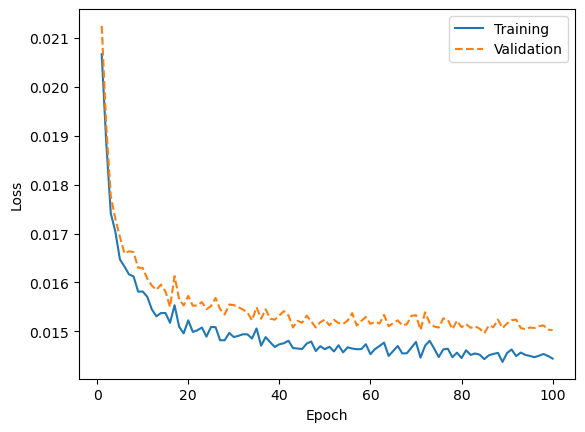

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

At this point, we're done with the warm-starting portion of base neural net training.

### Discretizing time

Before continuing to train the base neural net with a survival loss in PyTorch, we now discrete time just like in the DeepHit demo.

In [10]:
import numpy as np
from pycox.preprocessing.label_transforms import LabTransDiscreteTime

num_time_steps = 128  # set this to 0 to use all unique times of death

if num_time_steps == 0:
    mask = (D_train_np == 1)  # boolean mask specifying which training patients experienced death
    label_transform = LabTransDiscreteTime(np.unique(Y_train_np[mask]))
else:
    # use a quantile based discretization, which could possibly end up using fewer than the
    # number of time steps requested (if it turns out that in the dataset, there are many
    # duplicate observed times)
    label_transform = LabTransDiscreteTime(num_time_steps, scheme='quantiles')

Y_train_discrete_np, D_train_discrete_np = label_transform.fit_transform(Y_train_np, D_train_np)
Y_val_discrete_np, D_val_discrete_np = label_transform.transform(Y_val_np, D_val_np)
# note: PyCox's discretization code allows for the possibility that the event indicator changes
# (if a patient's survival time is known so that the event indicator is 1, but the survival time
# is after the maximum discrete time grid time, then the patient's event indicator is changed to
# being censored)

time_grid_train_np = label_transform.cuts
output_num_time_steps = len(time_grid_train_np)
print(f'Number of time steps to be used with DeepHit: {output_num_time_steps}')
print('Time grid:', time_grid_train_np)

Number of time steps to be used with DeepHit: 109
Time grid: [   0.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.
   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   26.
   27.   28.   30.   31.   33.   35.   37.   39.   41.   43.   45.   48.
   51.   54.   57.   59.   63.   66.   68.   73.   76.   82.   88.   92.
   97.  102.  108.  115.  120.  127.  135.  143.  151.  160.  167.  178.
  186.  198.  206.  217.  227.  236.  247.  261.  275.  292.  307.  328.
  344.  368.  384.  399.  417.  436.  452.  475.  496.  518.  539.  564.
  592.  624.  656.  678.  715.  757.  799.  827.  871.  923.  974. 1027.
 1085. 1131. 1184. 1228. 1258. 1345. 1415. 1530. 1599. 1690. 1760. 1813.
 2029.]


/home/george/Projects/survival-tutorial/pycox/preprocessing/discretization.py:37: UserWarning: cuts are not unique, continue with 109 cuts instead of 128
  warnings.warn(f"cuts are not unique, continue with {len(cuts)} cuts instead of {num}")


### Preparing training and validation sets for use with PyTorch

Note that at this point the observed times have been converted into discrete indices. Note that at the time of writing, the code is a bit picky about the data types used. When evaluating the loss later, the underlying PyCox code needs the event indicators to be cast as float32 (unlike in the DeepHit demo).

In [11]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_discrete_np, dtype=torch.int64, device=device)
D_train = torch.tensor(D_train_discrete_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_discrete_np, dtype=torch.int64, device=device)
D_val = torch.tensor(D_val_discrete_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the survival kernets model and loss

In [12]:
from survival_kernets.models import NKS

# - alpha and sigma hyperparameters mean the same as what they mean for the DeepHit loss
# - tau refers to the distance threshold in the embedding space
# - beta indicates how much compression to use for the training data
#   (beta = 0 means no compression, which corresponds to the original deep kernel
#    survival analysis method by Chen (2020) with the only difference being the
#    distance thresholding by tau, and the use of XGBoost instead of a random
#    survival forest warm start; as beta gets larger, we compress more so that
#    there are fewer and fewer exemplars/clusters)
min_kernel_weight = 1e-2  # only points with at least this kernel weight contribute to prediction
alpha = .9
sigma = .1
beta = .125
survival_kernets_model = NKS(base_neural_net, device=device,
                             alpha=alpha, sigma=sigma,
                             beta=beta, tau=np.sqrt(-np.log(min_kernel_weight)))
survival_kernets_loss = survival_kernets_model.loss

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [13]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 0.005

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = base_neural_net(X_batch)
        loss_batch = survival_kernets_loss(neural_net_output, Y_batch, D_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            train_loss += survival_kernets_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            val_loss += survival_kernets_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 9.426963806152344 - val loss 8.931456565856934
Epoch 2 - train loss 9.372712135314941 - val loss 8.700265884399414
Epoch 3 - train loss 9.118008613586426 - val loss 8.655265808105469
Epoch 4 - train loss 9.197836875915527 - val loss 8.636664390563965
Epoch 5 - train loss 8.98835563659668 - val loss 8.618515968322754
Epoch 6 - train loss 8.948002815246582 - val loss 8.605165481567383
Epoch 7 - train loss 9.083422660827637 - val loss 8.592860221862793
Epoch 8 - train loss 9.373239517211914 - val loss 8.581548690795898
Epoch 9 - train loss 9.086657524108887 - val loss 8.572205543518066
Epoch 10 - train loss 9.317073822021484 - val loss 8.563173294067383
Epoch 11 - train loss 9.187955856323242 - val loss 8.59142780303955
Epoch 12 - train loss 9.163077354431152 - val loss 8.589274406433105
Epoch 13 - train loss 9.084207534790039 - val loss 8.586626052856445
Epoch 14 - train loss 9.103545188903809 - val loss 8.582315444946289
Epoch 15 - train loss 9.025680541992188 - val

<All keys matched successfully>

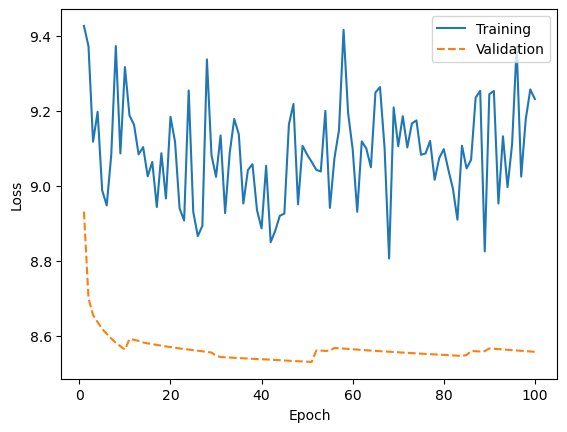

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

After training the base neural net, we construct the test-time predictor:

In [15]:
survival_kernets_model.training_data = (X_train_np.astype('float32'),
                                        (Y_train_discrete_np, D_train_discrete_np))
survival_kernets_model.train_embeddings = survival_kernets_model.predict(X_train_np.astype('float32'),
                                                                         batch_size=batch_size)
survival_kernets_model.duration_index = time_grid_train_np
survival_kernets_model.build_ANN_index()

### Summary function fine-tuning

We begin by making a backup copy of the summary functions (these are the death counts and at risk counts over time for the different exemplars). In case summary fine-tuning does not yield an improvement in a validation set evaluation metric of our choosing, then we could restore the summary functions (to what they were prior to summary function fine-tuning).

In [16]:
init_summary_functions = survival_kernets_model.get_summary_functions()

best_val_loss_no_summary_finetune = best_val_loss

Now we construct a new PyTorch model that views the kernel function as fixed and where we only optimize over the summary functions.

In [17]:
from survival_kernets.models import NKSSummary, NKSSummaryLoss

summary_finetune_net = NKSSummary(survival_kernets_model, init_summary_functions)
summary_finetune_loss = NKSSummaryLoss(alpha, sigma)

Next, we proceed with minibatch gradient descent.

In [18]:
summary_finetune_learning_rate = 0.01
summary_finetune_num_epochs = 20

optimizer = torch.optim.Adam(summary_finetune_net.parameters(),
                             lr=summary_finetune_learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(summary_finetune_num_epochs):
    summary_finetune_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = summary_finetune_net(X_batch)
        loss_batch = summary_finetune_loss(neural_net_output, Y_batch, D_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    summary_finetune_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = summary_finetune_net(X_batch)
            train_loss += summary_finetune_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = summary_finetune_net(X_batch)
            val_loss += summary_finetune_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(summary_finetune_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
summary_finetune_net.load_state_dict(best_params)

Epoch 1 - train loss 3.40061092376709 - val loss 3.3848989009857178
Epoch 2 - train loss 3.3637495040893555 - val loss 3.34053373336792
Epoch 3 - train loss 3.3443050384521484 - val loss 3.3154454231262207
Epoch 4 - train loss 3.334946870803833 - val loss 3.3029391765594482
Epoch 5 - train loss 3.330038547515869 - val loss 3.2950143814086914
Epoch 6 - train loss 3.32812237739563 - val loss 3.2921862602233887
Epoch 7 - train loss 3.327270269393921 - val loss 3.2899551391601562
Epoch 8 - train loss 3.3267364501953125 - val loss 3.2887532711029053
Epoch 9 - train loss 3.3264400959014893 - val loss 3.2874505519866943
Epoch 10 - train loss 3.326303720474243 - val loss 3.286989212036133
Epoch 11 - train loss 3.326160430908203 - val loss 3.2866296768188477
Epoch 12 - train loss 3.326157331466675 - val loss 3.2869176864624023
Epoch 13 - train loss 3.3261287212371826 - val loss 3.286989688873291
Epoch 14 - train loss 3.3261051177978516 - val loss 3.2878472805023193
Epoch 15 - train loss 3.32604

<All keys matched successfully>

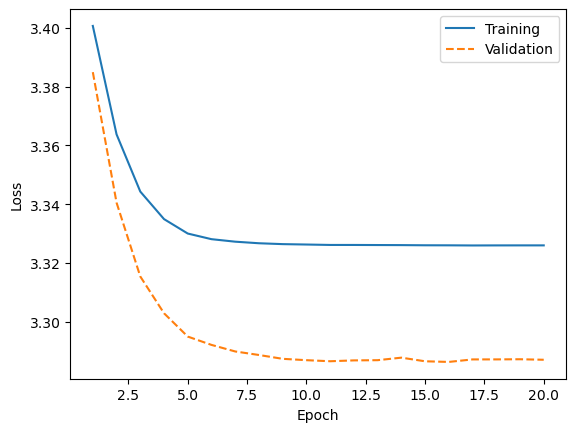

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, summary_finetune_num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, summary_finetune_num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

We use the validation set loss to decide on whether to use summary fine-tuning. To reiterate, it is possible to use other evaluation metrics on the validation set (e.g., validation set time-dependent concordance index, validation set integrated Brier score, etc) to decide on whether to use summary fine-tuning.

In [20]:
if best_val_loss < best_val_loss_no_summary_finetune:
    summary_functions, baseline_event_counts, baseline_at_risk_counts = \
        summary_finetune_net.get_exemplar_summary_functions_baseline_event_at_risk_counts()
    survival_kernets_model.load_summary_functions(summary_functions,
                                                  baseline_event_counts,
                                                  baseline_at_risk_counts)
else:
    survival_kernets_model.load_summary_functions(init_summary_functions)

### Predicting survival curves on the test set

We begin by preprocessing the test data using the preprocessor built using training data.

In [21]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')

Interpolation works the same way as in the DeepHit demo:

In [22]:
# here we interpolate by a factor of 10 (so that if we initially had m time steps, we would now have (m-1)*10 + 1 time steps)
interpolation_factor = 10
surv_test_interp_df = survival_kernets_model.interpolate(interpolation_factor).predict_surv_df(X_test_np, batch_size=batch_size)
time_grid_train_interp_np = surv_test_interp_df.index.to_numpy()  # the interpolated time grid is an interpolated version of the *training*  time grid
surv_test_interp_np = surv_test_interp_df.to_numpy().T

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

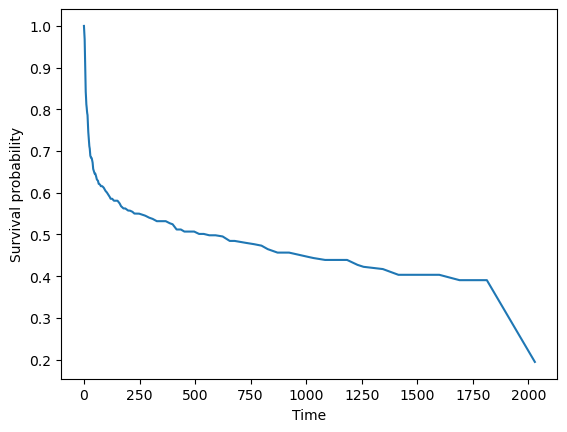

In [23]:
plt.plot(time_grid_train_interp_np, surv_test_interp_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing evaluation metrics on the test set

Here, we use the interpolated survival functions (along with their corresponding interpolated time grid).

As for choosing evaluation times, we still pick these based on the test set's observed times.

In [24]:
test_time_grid_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [25]:
from pycox.evaluation import EvalSurv

eval_pycox = EvalSurv(surv_test_interp_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')
print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6302629664790234


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [26]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(test_time_grid_np)),
                     int(.5 * len(test_time_grid_np)),
                     int(.75 * len(test_time_grid_np))]

for eval_time_index in eval_time_indices:
    eval_time = test_time_grid_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.603267594207427
Eval time 693.0 - truncated time-dependent concordance: 0.6026857087924367
Eval time 1291.0 - truncated time-dependent concordance: 0.6050356864762562


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [27]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = test_time_grid_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6679672922715647
Eval time 693.0 - time-dependent AUC: 0.7015429586503577
Eval time 1291.0 - time-dependent AUC: 0.7184124172219045


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [28]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_interp_np, time_grid_train_interp_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(test_time_grid_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.22805261301844926
Eval time 693.0 - Brier score: 0.20452402754000482
Eval time 1291.0 - Brier score: 0.18135020466774765
Integrated Brier score: 0.1842808943367774


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [29]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [30]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 604.3373353081078


In [31]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 721.5767421764164
